In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [23]:
a = 0
b = 0
def f(q):
    return logp(q), grad(q)

def logp(q):
    return -0.5 * ((q[0]+a)**2 + (q[1]+b)**2)


def grad(q):
    grad = np.zeros(2)
    grad[0] = -(q[0]+a)
    grad[1] = -(q[1]+b)  
    return grad

def target_density(q):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * ((q[0]+a)**2 + (q[1]+b)**2))
'''

def f(q):
    return logp(q), grad(q)

def logp(q):
    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])


def grad(q):
    grad = np.zeros(2)
    grad[0] = -q[0]*q[1]**2 + q[0] - 4
    grad[1] = -q[1]*q[0]**2 + q[1] - 4   
    return grad


def target_density(q):
    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))
'''

'\n\ndef f(q):\n    return logp(q), grad(q)\n\ndef logp(q):\n    return -0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1])\n\n\ndef grad(q):\n    grad = np.zeros(2)\n    grad[0] = -q[0]*q[1]**2 + q[0] - 4\n    grad[1] = -q[1]*q[0]**2 + q[1] - 4   \n    return grad\n\n\ndef target_density(q):\n    return np.exp(-0.5 * (q[0]**2*q[1]**2 + q[0]**2 + q[1]**2 - 8*q[0] - 8*q[1]))\n'

In [24]:
def update_PQUT(x_mem, grad_mem, U_mem, B1):
    Nq = np.shape(x_mem)[1]
    
    # firstly sort previous {xi} in ascending order with respect to its log function    
    o = np.argsort(U_mem)

    S = np.array([])
    Y = np.array([])
    v_last = 0
    v_next = 1
    init = True
    while v_next < len(o):
        sk = x_mem[v_next, :] - x_mem[v_last, :]  #s_k = x_{k+1} - x_k, vector
        yk = grad_mem[v_next, :] - grad_mem[v_last,:]  #y_k = f'_{k+1} - f'_k
        #sk = x_mem[o[v_next], :] - x_mem[o[v_last], :]  #s_k = x_{k+1} - x_k, vector
        #yk = grad_mem[o[v_next], :] - grad_mem[o[v_last],:]  #y_k = f'_{k+1} - f'_k
        if np.dot(sk, yk.T) > 0:
            v_last = v_next
            v_next = v_next + 1
            if init:
                S = np.hstack((S.copy(),sk.T))
                Y = np.hstack((Y.copy(),yk.T))
                init = False
            else:
                S = np.vstack((S.copy(),sk.T))
                Y = np.vstack((Y.copy(),yk.T))
        else:
            v_next += 1
            
    vn = np.shape(S)[0]
    P = np.zeros((Nq, vn))
    Q = np.zeros((Nq, vn))
    U = np.array([])
    T = np.array([])

    init =True
    for k in range(vn):
        syk = np.dot(S[k,:].T, Y[k,:])
        Bsk = Bz_product(U, T, B1, S[k,:])
        sBsk = np.dot(S[k,:].T, Bsk)

        P[:, k] = S[k,:] / syk
        Q[:, k] = np.dot(np.sqrt(syk/sBsk), Bsk) + Y[k,:]    
        t_k = S[k,:]/sBsk
        u_k = np.dot(np.sqrt(sBsk/syk), Y[k,:])+Bsk
        
        if init:
            T= np.hstack((T.copy(),t_k))
            U= np.hstack((U.copy(),u_k))
            init = False
        else:
            T= np.vstack((T.copy(),t_k)) #np.vstack((T.copy(),t_k))
            U= np.vstack((U.copy(),u_k))   #dimension: Vn x Nq

    return P, Q, U, T

In [25]:
def Bz_product(U, T, B1, z):
    #B = CC^T
    if U.size == 0:
        Bz = np.dot(B1, z)
        return Bz
    # compute C^T s
    CTz = CTz_product(U, T, B1, z)
    # compute Ns = CC^T s
    Bz = Cz_product(U, T, B1, CTz)
    return Bz
        
def CTz_product(U, T, B1, z):
    # compute C^T * sk
    C1 = np.sqrt(B1)
    Csk = z
    try:
        m = np.shape(U)[1]
        m = np.shape(U)[0]
    except:
        m = 1

    if m==1:
        Csk = Csk - np.dot(np.dot(U.T, Csk), T)
    else:
        for k in range(m-1, -1, -1):
        #for k in reversed(range(m))
            Csk = Csk - np.dot(np.dot(U[k,:].T, Csk), T[k,:])
            #print(m,np.shape(U), np.shape(Csk), np.shape(T))
           # Csk = Csk - np.dot(np.dot(U[:, k].T, Csk), T[:, k])
    
    CTz = np.dot(C1, Csk)
    return CTz

def Cz_product(U, T, B1, z):
    # compute C * CTs = C * C^T * sk
    # or compute C * z, where z ~ N(0,I)
    C1 = np.sqrt(B1)
    CCTsk = np.dot(C1, z)
    try:
        m = np.shape(U)[1]
        m = np.shape(U)[0]
    except:
        m = 1

    if m == 1:
        CCTsk = CCTsk - np.dot(np.dot(T.T, CCTsk), U)
    else:
        for k in range(m):
            CCTsk = CCTsk - np.dot(np.dot(T[k,:].T, CCTsk), U[k,:])   # Ck - uk * tk^T *Ck
   
    CCTz = CCTsk
    return CCTz

In [26]:
def Hz_product(P, Q, B1, z):
    # H = SS^T
    #if P.size == 0:
     #   Hz = np.linalg.inv(B1) @ z
    # compute S^Tz
    STz = STz_product(P, Q, B1, z)
    # compute SS^Tz
    Hz = Sz_product(P, Q, B1, STz)
    return Hz

def STz_product(P, Q, B1, z):
    # compute S^Tz
    S1 = np.diag(np.sqrt(np.diag(B1)))
    m = P.shape[1]
    Siz = z.copy()
    for i in reversed(range(m)):
        Siz -= np.dot(np.dot(P[:, i].T, Siz), Q[:, i])

    STz = np.dot(S1, Siz)
    return STz

def Sz_product(P, Q, B1, z):
    S1 = np.diag(np.sqrt(np.diag(B1)))
    m = P.shape[1]
    Siz = np.dot(S1, z)
    for i in range(m):
        Siz -= np.dot(np.dot(Q[:, i].T, Siz), P[:, i])
    Sz = Siz
    return Sz

In [27]:
def create_p(Nq):
    p = np.random.normal(loc=0, scale=1.0, size=Nq) 
    return p

def Kp(p, P, Q, B1):
    return 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T)) 


def leapfrog_BFGS(f, q, p, L, e, P, Q, B1):
    #L_rand = int(np.ceil(np.random.rand() * L))
    #eps = (0.9 + np.random.rand() / 5) * e
    L_rand = L
    eps = e
    
    Nq = len(q)
    X_path = np.zeros((L_rand+1, Nq))
    E_path = np.zeros(L_rand+1)
    K_path = np.zeros(L_rand+1)
    X_path[0, :] = q
    E_path[0], grad = f(q)
    g0 = -grad
    E_path[0] = -E_path[0]
    K_path[0] = 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T))  # Kp = 0.5 * p^T * M^-1 * P

    for i in range(1, L_rand+1):
        p = p + 1/2 * eps * grad
        q = q + eps * Hz_product(P, Q, B1, p.T).T  #massinv @ p
        E_new, grad = f(q)
        p = p + 1/2 * eps * grad
        
        X_path[i, :] = q
        E_path[i] = -E_new 
        K_path[i] = 0.5 * np.dot(p, Hz_product(P, Q, B1, p.T))
        
    g = -grad
    return X_path, E_path, K_path, g0, g

In [48]:
def hmcbfgs(f, M, M_adapt, sample_mem, L, epsilon, gamma, debug=False):
    
    Nq = np.shape(sample_mem)[1] # dimension of the model
    m = np.shape(sample_mem)[0] - 1  # selected previous 2:K samples
    acprate = 0

    #samples = [np.zeros((M // (m + 1), Nq)) for _ in range(m + 1)]    # (m+1)=K-chains with M samples in total
    samples = []

    B1 = np.eye(Nq) * gamma # Initialize the starting Hessian matrix (mass matrix)

    
    ### Initalize memory excluding the first sample in the memory ###
    sample  = sample_mem[0, :]  # x_1^(t)
    x_mem = sample_mem[1:, :]  # x_{2:k}, //matrix//  K-1 x Nq dims
    grad_mem = np.zeros((m, Nq))  # gradient, //matrix//  K-1 x Nq dims
    U_mem = np.zeros(m)  # potential energy, //vector// K-1 dims

    # save potential energy and gradient for previous 2:K samples
    for k in range(m):
        x_k = x_mem[k, :]
        logp, grad = f(x_k)
        U_mem[k] = -logp
        grad_mem[k,:] = -grad

    ### Start HMC sampling ....... ###
    for i in range(M + M_adapt):
        
        if np.mod(i,500) == 0:
            print('sampling iteration {}'.format(i))

        # precompute BFGS-conjugate matrices
        P, Q, U, T = update_PQUT(x_mem, grad_mem, U_mem, B1)

        # randomly draw momentum from B
        p = create_p(Nq)  
        p = Cz_product(U, T, B1, p.T)  
        p = p.T

        # simulate trajectory
        X_path, E_path, K_path, g0, g = leapfrog_BFGS(f, sample, p, L, epsilon, P, Q, B1)

        if debug:
            plt.figure(1)
            plt.plot(X_path[:, 0], X_path[:, -1], '.-')
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.figure(2)
            plt.clf()
            plt.plot(E_path, 'blue')
            plt.plot(K_path, 'red')
            plt.plot(E_path + K_path,'--')
            plt.grid()
            plt.pause(0.1)
        
        # accept or reject?
        H_current = E_path[0] + K_path[0]
        H_proposed = E_path[-1] + K_path[-1]
        
        denergy = H_current - H_proposed
        acceptance_prob = min(0, denergy)
        alpha = np.log(np.random.rand())

        '''        
        sample_next = x_mem[0, :]
        if alpha < acceptance_prob:
            # !!!Accept
            sample = X_path[-1,:]
            # update memory
            x_mem = np.vstack((x_mem[1:, :], sample))
            grad_mem = np.vstack((grad_mem[1:, :], g))
            U_mem = np.hstack((U_mem[1:], E_path[-1]))

            if i >= M_adapt:
                acprate += 1
                samples.append(sample)
        else:
            # update memory
            x_mem = np.vstack((x_mem[1:, :], sample))     #raw code
            grad_mem = np.vstack((grad_mem[1:, :], g0))
            U_mem = np.hstack((U_mem[1:], E_path[0]))

        sample = sample_next
        '''
        sample = x_mem[0, :]
        if alpha < acceptance_prob:
            # !!!Accept
            sample = X_path[-1,:]
            # update memory
            x_mem = np.vstack((x_mem[1:, :], sample))
            grad_mem = np.vstack((grad_mem[1:, :], g))
            U_mem = np.hstack((U_mem[1:], E_path[-1]))

            if i >= M_adapt:
                acprate += 1
                samples.append(sample)
        else:
            # update memory
            x_mem = np.vstack((x_mem[1:, :], x_mem[-1, :]))     # from paper
            grad_mem = np.vstack((grad_mem[1:, :], grad_mem[-1, :]))
            U_mem = np.hstack((U_mem[1:], U_mem[-1]))

        

    '''
    if i > M_adapt:
        acprate = acprate + accept
        ensemble_id = i % (k + 1)
        subiter_id = (i - M_adapt) // (k + 1)
        samples[ensemble_id][subiter_id, :] = sample
    '''
    samples = np.array(samples)
    print('Acceptance_rate = {}'.format(acprate/M))
    return samples

In [55]:
random.seed(2)
M = 5000
M_adapt =500
k=10
sample_mem = np.random.rand(k, 2)
L = 50
Eps = 0.5
gamma = 0.1
debug=False


t_start = time.time()
print('Running HMC with L-BFGS')
samples = hmcbfgs(f, M, M_adapt, sample_mem, L, Eps, gamma,debug)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

Running HMC with L-BFGS
sampling iteration 0
sampling iteration 500
sampling iteration 1000
sampling iteration 1500
sampling iteration 2000
sampling iteration 2500
sampling iteration 3000
sampling iteration 3500
sampling iteration 4000
sampling iteration 4500
sampling iteration 5000
Acceptance_rate = 0.9998
Sampling Completed in 25.47 seconds


In [56]:
def plot_prediction(samples, target_density=target_density,save_file=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 2], height_ratios=[2, 2], wspace=0.15, hspace=0.15)

    ax1 = fig.add_subplot(gs[0, 0])
    # generate grids
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)

    # compute the posterior density
    Z = target_density([X,Y])

    # plot samples

    ax1.plot(samples[:, 0], samples[:, 1], 'r+')
    # plot contour
    contour = plt.contour(X, Y, Z, cmap='viridis')
    ax1.clabel(contour, inline=1, fontsize=10)
    ax1.annotate(f'#Samples: {len(samples)}', xy=(5, 5), xytext=(5, 5),
                       ha='center', va='bottom')


    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.set_xlabel("x-samples")
    ax2.set_ylabel("density")
    data = samples[:,0]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax2.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax2.hist(data, bins=20,color='k',edgecolor='k',density=True, alpha=0.5)
    ax2.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax2.xaxis.set_tick_params(labelleft=False)


    ax3 = fig.add_subplot(gs[0, 1], sharey=ax1) 
    ax3.set_ylabel("y-samples")
    ax3.set_xlabel("density")
    data = samples[:,1]
    mu, sigma = np.mean(data), np.std(data)
    '''
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    gaussian = norm.pdf(x, mu, sigma)
    ax3.plot(x, gaussian, color='red', label='Gaussian Distribution')
    '''
    ax3.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True, orientation='horizontal')
    ax3.set_title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
    ax3.yaxis.set_tick_params(labelleft=False)

    ax_blank = fig.add_subplot(gs[1, 1])
    ax_blank.axis('off')

    plt.tight_layout()
    if not save_file:
        plt.show()
    else:
        plt.savefig(save_file)
    


In [57]:
def autocorrelation(chain, lag):
    M = len(chain)
    mean = np.mean(chain)
    var = np.sum((chain - mean) ** 2) / M
    return np.sum((chain[:M-lag] - mean) * (chain[lag:] - mean)) / (M - lag) / var

def autocorrelation_function(chain, max_lag):
    return np.array([autocorrelation(chain, lag) for lag in range(max_lag)])

def integrated_autocorrelation_time(autocorr, M):
    # Use a cutoff when autocorrelation lower than 0.05
    cuttoff_autocorr = autocorr[autocorr > 0.05]
    M_cutoff = len(cuttoff_autocorr)

    sum = 0
    for s in range(M_cutoff):
        sum += cuttoff_autocorr[s] * (1 - s/M)
    
    return 1 + 2 * sum

def effective_sample_size(chain, max_lag):
    M = len(chain)
    autocorr = autocorrelation_function(chain, max_lag)
    tau = integrated_autocorrelation_time(autocorr, M)
    ess = M / tau
    return ess 

# 可视化自相关函数
def plot_autocorrelation(chain, max_lag, label,save_file=None):
    fig = plt.figure(figsize=(10, 10))
    autocorr = autocorrelation_function(chain, max_lag)
    lags = np.arange(max_lag)
    
    plt.figure(figsize=(10, 5))
    plt.stem(lags, autocorr, linefmt='lightblue')
    plt.xlabel('Lag')
    plt.ylabel(f'{label} Autocorrelation')
    plt.title('Autocorrelation Function')
    plt.axhline(y=0.05, color='g', linestyle='--', linewidth=1)
    plt.axhline(y=-0.05, color='g', linestyle='--', linewidth=1)
    plt.grid(True)
    if not save_file:
        plt.show()
    else:
        plt.savefig(save_file)


In [58]:
def plot_loglikelihood(A, alpha, save_file=None):
    fig = plt.figure(figsize=(10, 10))
    #plt.figure(1)
    alpha = 0
    # Print Monte-Carlo estimate of alpha.
    print("Mean:  " + str(np.mean(A)))
    per = np.percentile(A, [16, 50, 84])
    print("Alpha = {} (+{} / - {})".format( per[1], per[2] - per[1], per[1] - per[0] ))

    n, b = np.histogram(A, 30)
    x = 0.5 * (b[:-1] + b[1:])
    y = n.astype(float) / n.sum()
    plt.step(x, y, color='b', lw=3, where='mid')


    ylim = plt.ylim()
    plt.vlines(alpha, 0, ylim[1], color='r', lw=3)
    plt.vlines(per, 0., max(y), linestyle='--', color='b', lw=1)
    plt.ylim(ylim)
    plt.xlabel(r'$\alpha$', fontsize=24)
    plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=24)

    if save_file:
        plt.savefig(save_file)
    else:
        plt.show()

/var/folders/st/h8zl89fn7f7gj0l06p3q5wj40000gn/T/ipykernel_14838/314012440.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


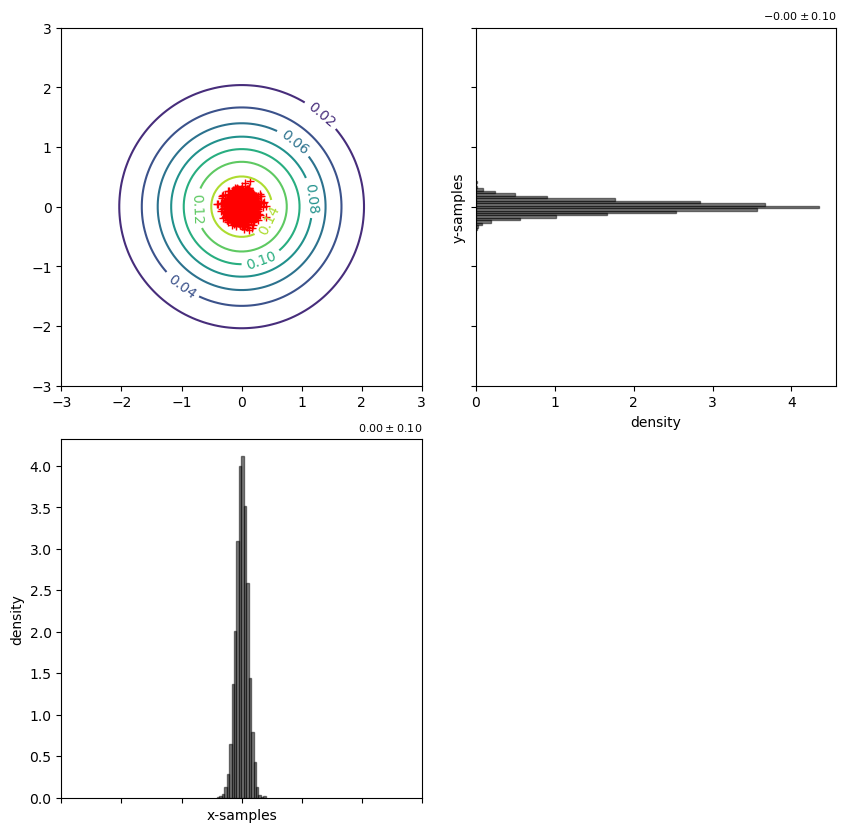

In [59]:
plot_prediction(samples, target_density, save_file = '/Users/gangyang/Desktop/figs/1.png')


Effective Sample Size (ESS): 309.10444978230356


<Figure size 1000x1000 with 0 Axes>

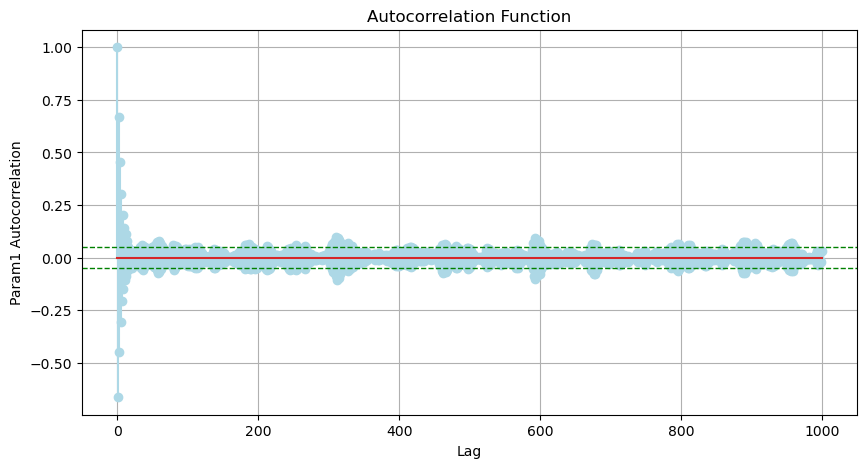

Mean:  0.0010387436028110675
Alpha = 0.0021029171088354616 (+0.09420329290155321 / - 0.0986881200207578)


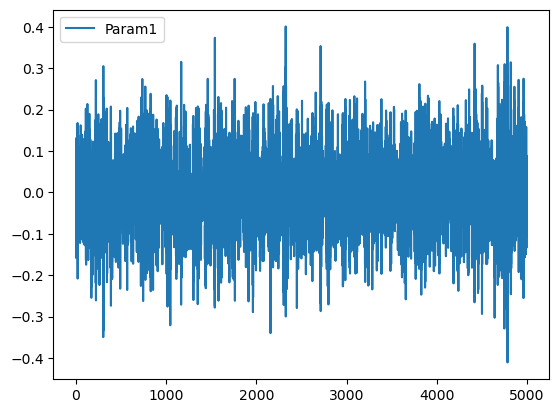

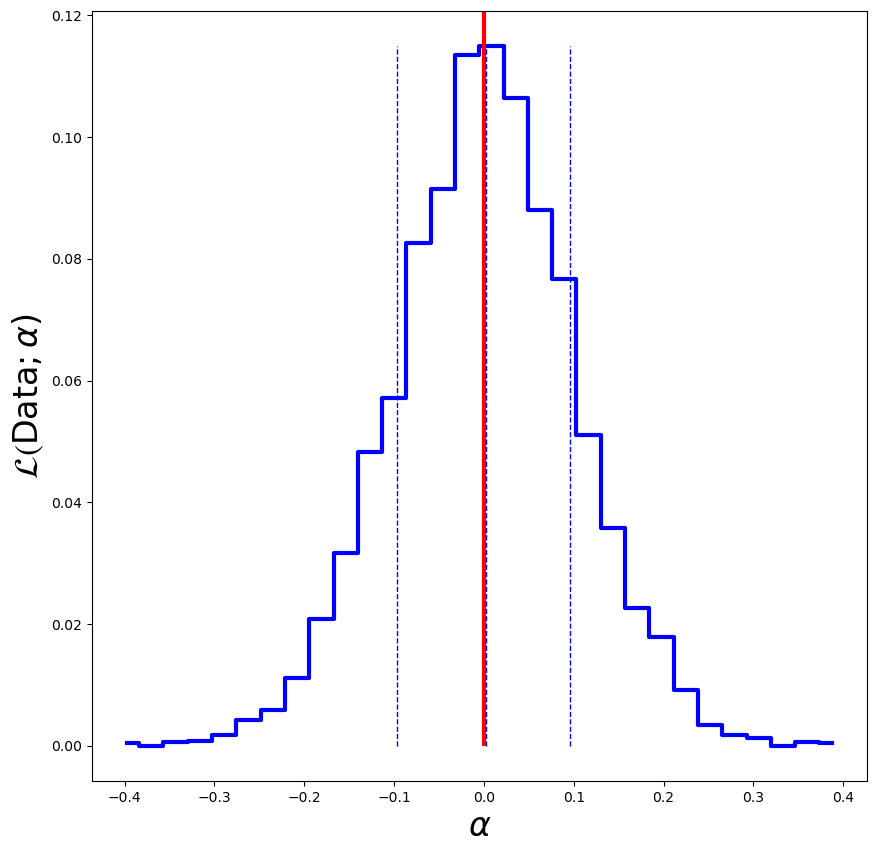

In [60]:
#  parameter 1
max_lag = 1000
data = samples[:,0]
ess = effective_sample_size(data, max_lag)
print("Effective Sample Size (ESS):", ess)
plot_autocorrelation(data, max_lag, label='Param1')
plt.plot(data, label='Param1')
plt.legend()

plot_loglikelihood(samples[:,0], 1)
